# Analyse; Anvendt Økonomi med konsulentmetode
## Eksekveringsplan
Boligprisudviklingen

Sammenligning med national udvikling

Parallelle trends

Difference in Difference

Fjernarbejde (Baseline)

Fjernarbejde med kontrolvariabler

Post COVID-effekt

Socioøkonomiske faktorer

Policy implikationer


### Boligprisudviklingen
- Indlæs renset BM011-data
- Tjek kommune-ID og tidsenheder
- Klassificer kommuner i by og provins
- Lav tidsserieplot af boligpriser (By/Provins)

In [119]:
# Preamble

# =========================
# Robust preamble
# =========================

from pathlib import Path
import pandas as pd
import os
import sys
from datetime import datetime

# Projekt-rod (ret hvis nødvendigt)
PROJECT_DIR = Path("/Users/victorpraud/Desktop")

DATA_DIR   = PROJECT_DIR
OUTPUT_DIR = PROJECT_DIR / "output"
FIG_DIR    = PROJECT_DIR / "figures"

# Opret mapper hvis de ikke findes
for d in [OUTPUT_DIR, FIG_DIR]:
    d.mkdir(exist_ok=True)

# QA: vis working directory
print("Working directory:", os.getcwd())
print("Project directory:", PROJECT_DIR)

# QA: tjek at vigtige filer findes
required_files = [
    DATA_DIR / "BM011_prices_clean.xlsx",
    DATA_DIR / "Kommune_groups_clean.xlsx"
]

for f in required_files:
    assert f.exists(), f"❌ Mangler fil: {f}"

print("✅ Alle nødvendige filer fundet")

# Versions-/tidsstempel
RUN_DATE = datetime.now().strftime("%Y-%m-%d %H:%M")
print("Run date:", RUN_DATE)


Working directory: /Users/victorpraud/Desktop
Project directory: /Users/victorpraud/Desktop
✅ Alle nødvendige filer fundet
Run date: 2025-12-25 21:50


#### Indlæs renset BM011-data, tjek ID og tidsenheder, klassificer kommuner

In [120]:
from pathlib import Path
import pandas as pd

file_path = Path("/Users/victorpraud/Desktop/BM011_prices_clean.xlsx")

df = pd.read_excel(file_path, sheet_name="prices")

print(df.shape)
print(df.columns.tolist())
df.head()


(94, 31)
['ID', 'Kommune', '2018K2', '2018K3', '2018K4', '2019K1', '2019K2', '2019K3', '2019K4', '2020K1', '2020K2', '2020K3', '2020K4', '2021K1', '2021K2', '2021K3', '2021K4', '2022K1', '2022K2', '2022K3', '2022K4', '2023K1', '2023K2', '2023K3', '2023K4', '2024K1', '2024K2', '2024K3', '2024K4', '2025K1', '2025K2']


,ID,Kommune,2018K2,2018K3,2018K4,2019K1,2019K2,2019K3,2019K4,2020K1,...,2023K1,2023K2,2023K3,2023K4,2024K1,2024K2,2024K3,2024K4,2025K1,2025K2
0,101,København,37735.0,37529.0,37781.0,37689.0,37704.5,37868.5,39196.5,38606.0,...,44202.0,45846.5,47742.5,48383.5,47700.0,50594.5,51516.0,52998.5,55121.5,57920.5
1,151,Ballerup,25757.0,24606.5,24525.0,25809.5,25538.5,25859.5,25241.0,25285.0,...,28619.5,28418.5,29968.5,30830.0,28932.5,31624.5,31269.0,31602.5,31898.5,34869.5
2,153,Brøndby,23261.5,22996.5,22453.5,23209.0,23763.5,25366.0,25617.0,24345.5,...,27103.0,27288.5,26227.0,25885.5,27859.0,29854.0,28456.0,29424.0,30704.0,29708.0
3,157,Gentofte,39575.0,40447.5,40214.5,41022.0,41595.0,42164.0,42460.0,43435.5,...,47417.5,51043.0,53418.0,50751.5,50939.0,52384.0,52979.5,56403.0,57633.0,58122.0
4,159,Gladsaxe,29686.5,30771.5,29818.0,29698.5,30888.0,30664.5,30112.5,31413.5,...,34186.5,33959.5,35065.0,35696.0,35139.0,37141.5,37815.5,37686.0,39458.5,41182.0


In [121]:
# Overblik over kommune-ID
print("Antal rækker:", len(df))
print("Unikke kommune-ID:", df["ID"].nunique())

# Tjek for mangler og duplikater
print("Manglende ID:", df["ID"].isna().sum())
print("Duplikerede ID:", df["ID"].duplicated().sum())

# Vis et udsnit
df[["ID", "Kommune"]].head(10)


Antal rækker: 94
Unikke kommune-ID: 94
Manglende ID: 0
Duplikerede ID: 0


,ID,Kommune
0,101,København
1,151,Ballerup
2,153,Brøndby
3,157,Gentofte
4,159,Gladsaxe
5,161,Glostrup
6,163,Herlev
7,165,Albertslund
8,167,Hvidovre
9,169,Høje-Taastrup


In [122]:
# Find alle tidskolonner (kvartaler)
time_cols = [c for c in df.columns if c not in ["ID", "Kommunenavn"]]

print("Antal kvartaler:", len(time_cols))
print("Første 5 kvartaler:", time_cols[:5])
print("Sidste 5 kvartaler:", time_cols[-5:])

import re

bad_cols = [c for c in time_cols if not re.match(r"^\d{4}K[1-4]$", c)]
print("Kolonner med forkert format:", bad_cols)


Antal kvartaler: 30
Første 5 kvartaler: ['Kommune', '2018K2', '2018K3', '2018K4', '2019K1']
Sidste 5 kvartaler: ['2024K2', '2024K3', '2024K4', '2025K1', '2025K2']
Kolonner med forkert format: ['Kommune']


In [123]:
import os
os.listdir("/Users/victorpraud/Desktop")


['~$BM011_prices_clean.xlsx',
 '.DS_Store',
 'VAEKST',
 '.localized',
 'Recovered files',
 'BM011 Renset.xlsx',
 'Polit Case Competition',
 'Nora konfirmation',
 'output',
 'Gave til far.pdf',
 '~$Kommune_groups_clean.xlsx',
 '~$ivatlivspolitik.docx',
 'Team Nørrebro Håndbold',
 'Kandidat - Årsprøve 1',
 'figures',
 'BM011_prices_clean.xlsx',
 'Jobssøgning',
 'BM011_Renset.xlsx',
 'Østerbrogården',
 '~$reløbig Privacy Policy PCC 2.docx',
 'Polit - Bachelor',
 'Polit - 4 årsprøve',
 'Kommune_groups_clean.xlsx']

In [124]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/Users/victorpraud/Desktop")

# Find alle Excel-filer på Desktop der indeholder "kommune" og "group"
cands = sorted([p for p in DATA_DIR.glob("*.xlsx") if "kommune" in p.name.lower() and "group" in p.name.lower()])

print("Kandidater:")
for p in cands:
    print(" -", p.name)

# Vælg den første kandidat automatisk
file_path = cands[0]
print("\nBruger:", file_path)

groups = pd.read_excel(file_path)
groups.head()


Kandidater:
 - Kommune_groups_clean.xlsx
 - ~$Kommune_groups_clean.xlsx

Bruger: /Users/victorpraud/Desktop/Kommune_groups_clean.xlsx


,ID,Kommune,Gruppe
0,101,København,City
1,151,Ballerup,Urban
2,153,Brøndby,Urban
3,157,Gentofte,Urban
4,159,Gladsaxe,Urban


In [125]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("/Users/victorpraud/Desktop")

# Find alle Excel-filer på Desktop der indeholder "kommune" og "group"
cands = sorted([p for p in DATA_DIR.glob("*.xlsx") if "kommune" in p.name.lower() and "group" in p.name.lower()])

print("Kandidater:")
for p in cands:
    print(" -", p.name)

# Vælg den første kandidat automatisk
file_path = cands[0]
print("\nBruger:", file_path)

groups = pd.read_excel(file_path)
groups.head()


Kandidater:
 - Kommune_groups_clean.xlsx
 - ~$Kommune_groups_clean.xlsx

Bruger: /Users/victorpraud/Desktop/Kommune_groups_clean.xlsx


,ID,Kommune,Gruppe
0,101,København,City
1,151,Ballerup,Urban
2,153,Brøndby,Urban
3,157,Gentofte,Urban
4,159,Gladsaxe,Urban


In [126]:
print(df.columns)
print(groups.columns)


Index(['ID', 'Kommune', '2018K2', '2018K3', '2018K4', '2019K1', '2019K2',
       '2019K3', '2019K4', '2020K1', '2020K2', '2020K3', '2020K4', '2021K1',
       '2021K2', '2021K3', '2021K4', '2022K1', '2022K2', '2022K3', '2022K4',
       '2023K1', '2023K2', '2023K3', '2023K4', '2024K1', '2024K2', '2024K3',
       '2024K4', '2025K1', '2025K2'],
      dtype='object')
Index(['ID', 'Kommune', 'Gruppe'], dtype='object')


In [127]:
import pandas as pd
import os
os.chdir("/Users/victorpraud/Desktop")

bm = pd.read_excel("BM011_prices_clean.xlsx")
grp = pd.read_excel("Kommune_groups_clean.xlsx")

df = bm.merge(grp[["ID", "Gruppe"]], on="ID", how="left")

cols = list(df.columns)
cols.insert(cols.index("Kommune") + 1, cols.pop(cols.index("Gruppe")))
df = df[cols]

print(df.columns)
print(df.head())

df[["ID", "Kommune", "Gruppe", "2018K2"]].head(10)



Index(['ID', 'Kommune', 'Gruppe', '2018K2', '2018K3', '2018K4', '2019K1',
       '2019K2', '2019K3', '2019K4', '2020K1', '2020K2', '2020K3', '2020K4',
       '2021K1', '2021K2', '2021K3', '2021K4', '2022K1', '2022K2', '2022K3',
       '2022K4', '2023K1', '2023K2', '2023K3', '2023K4', '2024K1', '2024K2',
       '2024K3', '2024K4', '2025K1', '2025K2'],
      dtype='object')
    ID    Kommune Gruppe   2018K2   2018K3   2018K4   2019K1   2019K2  \
0  101  København   City  37735.0  37529.0  37781.0  37689.0  37704.5   
1  151   Ballerup  Urban  25757.0  24606.5  24525.0  25809.5  25538.5   
2  153    Brøndby  Urban  23261.5  22996.5  22453.5  23209.0  23763.5   
3  157   Gentofte  Urban  39575.0  40447.5  40214.5  41022.0  41595.0   
4  159   Gladsaxe  Urban  29686.5  30771.5  29818.0  29698.5  30888.0   

    2019K3   2019K4  ...   2023K1   2023K2   2023K3   2023K4   2024K1  \
0  37868.5  39196.5  ...  44202.0  45846.5  47742.5  48383.5  47700.0   
1  25859.5  25241.0  ...  28619.5  28418

,ID,Kommune,Gruppe,2018K2
0,101,København,City,37735.0
1,151,Ballerup,Urban,25757.0
2,153,Brøndby,Urban,23261.5
3,157,Gentofte,Urban,39575.0
4,159,Gladsaxe,Urban,29686.5
5,161,Glostrup,Urban,25553.5
6,163,Herlev,Urban,25237.5
7,165,Albertslund,Urban,21159.0
8,167,Hvidovre,Urban,26218.0
9,169,Høje-Taastrup,Urban,20946.5


In [128]:
# Kopier dataframe til brug i opgaven:
prices_plot = df.copy()
prices_stat = df.copy()
prices_ts = df.copy()

prices_plot.head()

,ID,Kommune,Gruppe,2018K2,2018K3,2018K4,2019K1,2019K2,2019K3,2019K4,...,2023K1,2023K2,2023K3,2023K4,2024K1,2024K2,2024K3,2024K4,2025K1,2025K2
0,101,København,City,37735.0,37529.0,37781.0,37689.0,37704.5,37868.5,39196.5,...,44202.0,45846.5,47742.5,48383.5,47700.0,50594.5,51516.0,52998.5,55121.5,57920.5
1,151,Ballerup,Urban,25757.0,24606.5,24525.0,25809.5,25538.5,25859.5,25241.0,...,28619.5,28418.5,29968.5,30830.0,28932.5,31624.5,31269.0,31602.5,31898.5,34869.5
2,153,Brøndby,Urban,23261.5,22996.5,22453.5,23209.0,23763.5,25366.0,25617.0,...,27103.0,27288.5,26227.0,25885.5,27859.0,29854.0,28456.0,29424.0,30704.0,29708.0
3,157,Gentofte,Urban,39575.0,40447.5,40214.5,41022.0,41595.0,42164.0,42460.0,...,47417.5,51043.0,53418.0,50751.5,50939.0,52384.0,52979.5,56403.0,57633.0,58122.0
4,159,Gladsaxe,Urban,29686.5,30771.5,29818.0,29698.5,30888.0,30664.5,30112.5,...,34186.5,33959.5,35065.0,35696.0,35139.0,37141.5,37815.5,37686.0,39458.5,41182.0


#### Beregn gennemsnit, median og vækstrater for boligpriser i by og provins

In [129]:
import pandas as pd
import numpy as np

# meta-kolonner (justér kun hvis nødvendigt)
meta_cols = ["ID", "Kommune", "Gruppe"]

# tidskolonner = resten
time_cols = [c for c in prices_ts.columns if c not in meta_cols]

print("Antal kvartaler:", len(time_cols))
print("Første:", time_cols[:3], "Sidste:", time_cols[-3:])

# sikr numerisk
prices_ts[time_cols] = prices_ts[time_cols].apply(pd.to_numeric, errors="coerce")


Antal kvartaler: 29
Første: ['2018K2', '2018K3', '2018K4'] Sidste: ['2024K4', '2025K1', '2025K2']


In [130]:
# Definér meta-kolonner eksplicit
meta_cols = ["ID", "Kommune", "Gruppe"]

# Tidskolonner = resten
time_cols = [c for c in prices_stat.columns if c not in meta_cols]

print("Antal tidskolonner:", len(time_cols))
print("Eksempel:", time_cols[:5])



Antal tidskolonner: 29
Eksempel: ['2018K2', '2018K3', '2018K4', '2019K1', '2019K2']


In [131]:
# Melt til long format
prices_long = prices_stat.melt(
    id_vars=meta_cols,
    value_vars=time_cols,
    var_name="quarter",
    value_name="price_m2"
)

print("Shape:", prices_long.shape)
prices_long.head()


Shape: (2726, 5)


,ID,Kommune,Gruppe,quarter,price_m2
0,101,København,City,2018K2,37735.0
1,151,Ballerup,Urban,2018K2,25757.0
2,153,Brøndby,Urban,2018K2,23261.5
3,157,Gentofte,Urban,2018K2,39575.0
4,159,Gladsaxe,Urban,2018K2,29686.5


In [132]:
import numpy as np

# Konverter "2019K3" → 20193 (eller tilsvarende ordinal)
prices_long["t"] = (
    prices_long["quarter"]
    .str.replace("K", "")
    .astype(int)
)

# Sortér korrekt
prices_long = prices_long.sort_values(["ID", "t"])

prices_long.head()


,ID,Kommune,Gruppe,quarter,price_m2,t
0,101,København,City,2018K2,37735.0,20182
94,101,København,City,2018K3,37529.0,20183
188,101,København,City,2018K4,37781.0,20184
282,101,København,City,2019K1,37689.0,20191
376,101,København,City,2019K2,37704.5,20192


In [133]:
# Gennemsnitspriser (pr. kvartal)
summary_stats = (
    prices_long
    .groupby(["Gruppe", "quarter"])["price_m2"]
    .agg(
        mean_price="mean",
        median_price="median"
    )
    .reset_index()
)

summary_stats.head()

# vælg basisperiode
base_q = "2018K2"

base = (
    summary_stats[summary_stats["quarter"] == base_q]
    .set_index("Gruppe")["mean_price"]
)

summary_stats["price_index"] = (
    summary_stats["mean_price"] /
    summary_stats["Gruppe"].map(base) * 100
)

summary_stats.head()



,Gruppe,quarter,mean_price,median_price,price_index
0,City,2018K2,25134.625,22642.00,100.000000
1,City,2018K3,24695.000,22217.50,98.250919
2,City,2018K4,24779.875,22396.75,98.588600
3,City,2019K1,24724.125,22227.50,98.366795
4,City,2019K2,25204.625,23089.75,100.278500


In [134]:
# Vækstrater pr. kvartal
prices_long["log_price"] = np.log(prices_long["price_m2"])

prices_long["growth_q"] = (
    prices_long
    .groupby("ID")["log_price"]
    .diff()
)

prices_long.head()


,ID,Kommune,Gruppe,quarter,price_m2,t,log_price,growth_q
0,101,København,City,2018K2,37735.0,20182,10.538343,NaN
94,101,København,City,2018K3,37529.0,20183,10.532869,-0.005474
188,101,København,City,2018K4,37781.0,20184,10.539562,0.006692
282,101,København,City,2019K1,37689.0,20191,10.537124,-0.002438
376,101,København,City,2019K2,37704.5,20192,10.537535,0.000411


#### Lav tidsserieplot af boligpriser (By/Provins)

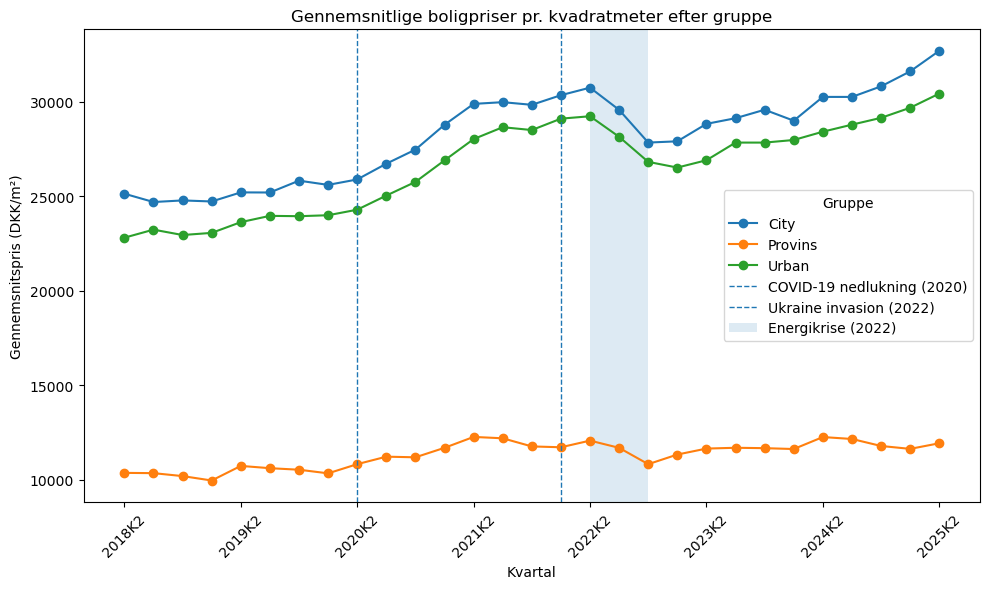

In [135]:
# Plot gennemsnit pr. gruppe over tid
import matplotlib.pyplot as plt

# Anvend summary_stats fra tidligere
fig, ax = plt.subplots(figsize=(10, 6))

for g in summary_stats["Gruppe"].unique():
    #if g not in ["City", "Provins"]:
    #    continue
    d = summary_stats[summary_stats["Gruppe"] == g]
    ax.plot(d["quarter"], d["mean_price"], marker="o", label=g)

ax.axvline("2020K2", linestyle="--", linewidth=1, label="COVID-19 nedlukning (2020)")
ax.axvline("2022K1", linestyle="--", linewidth=1, label="Ukraine invasion (2022)")
ax.axvspan("2022K2", "2022K4", alpha=0.15, label="Energikrise (2022)")

ax.set_title("Gennemsnitlige boligpriser pr. kvadratmeter efter gruppe")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Gennemsnitspris (DKK/m²)")
ax.legend(title="Gruppe")

# Gør x-aksen læsbar
ax.set_xticks(d["quarter"][::4])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

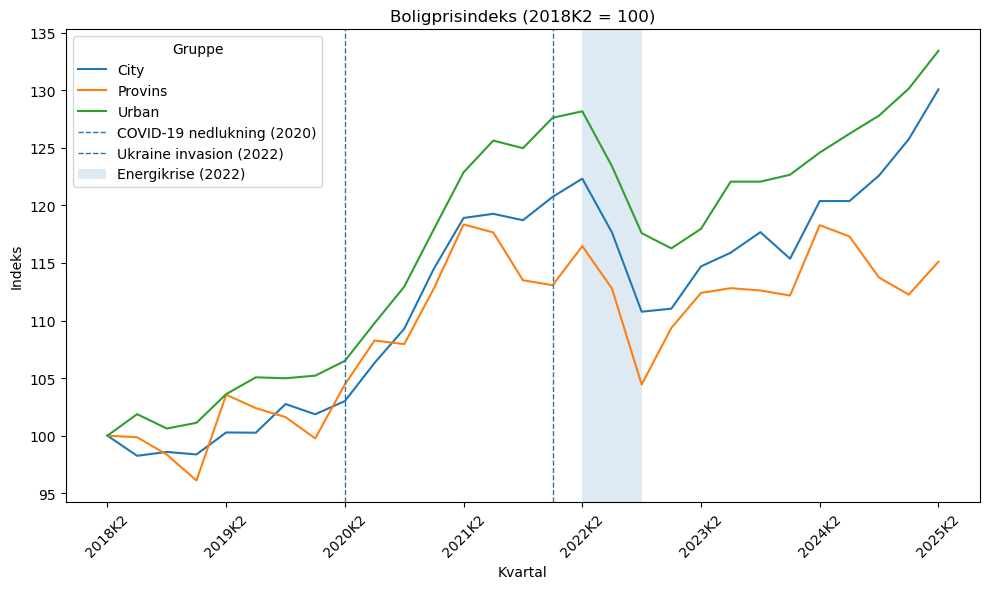

In [136]:
fig, ax = plt.subplots(figsize=(10, 6))

for g in summary_stats["Gruppe"].unique():
     #if g not in ["City", "Provins"]:
    #    continue
    d = summary_stats[summary_stats["Gruppe"] == g]
    ax.plot(d["quarter"], d["price_index"], label=g)

ax.axvline("2020K2", linestyle="--", linewidth=1, label="COVID-19 nedlukning (2020)")
ax.axvline("2022K1", linestyle="--", linewidth=1, label="Ukraine invasion (2022)")
ax.axvspan("2022K2", "2022K4", alpha=0.15, label="Energikrise (2022)")

ax.set_title("Boligprisindeks (2018K2 = 100)")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Indeks")
ax.legend(title="Gruppe")

ax.set_xticks(d["quarter"][::4])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


#### Sammenligning med national udvikling

In [137]:
# Nationalt gennemsnit pr. kvartal
national = (
    prices_long
    .groupby("quarter")["price_m2"]
    .mean()
    .reset_index()
    .rename(columns={"price_m2": "national_mean"})
)

national.head()

compare = summary_stats.merge(
    national,
    on="quarter",
    how="left"
)

compare.head()


,Gruppe,quarter,mean_price,median_price,price_index,national_mean
0,City,2018K2,25134.625,22642.00,100.000000,15051.835106
1,City,2018K3,24695.000,22217.50,98.250919,15169.723404
2,City,2018K4,24779.875,22396.75,98.588600,15040.349462
3,City,2019K1,24724.125,22227.50,98.366795,14864.505319
4,City,2019K2,25204.625,23089.75,100.278500,15562.531915


In [138]:
base_q = "2018K2"

# national indeks
national_base = national.loc[national["quarter"] == base_q, "national_mean"].iloc[0]
national["national_index"] = national["national_mean"] / national_base * 100

# merge igen
compare = compare.merge(
    national[["quarter", "national_index"]],
    on="quarter",
    how="left"
)

compare.head()





,Gruppe,quarter,mean_price,median_price,price_index,national_mean,national_index
0,City,2018K2,25134.625,22642.00,100.000000,15051.835106,100.000000
1,City,2018K3,24695.000,22217.50,98.250919,15169.723404,100.783215
2,City,2018K4,24779.875,22396.75,98.588600,15040.349462,99.923693
3,City,2019K1,24724.125,22227.50,98.366795,14864.505319,98.755436
4,City,2019K2,25204.625,23089.75,100.278500,15562.531915,103.392921


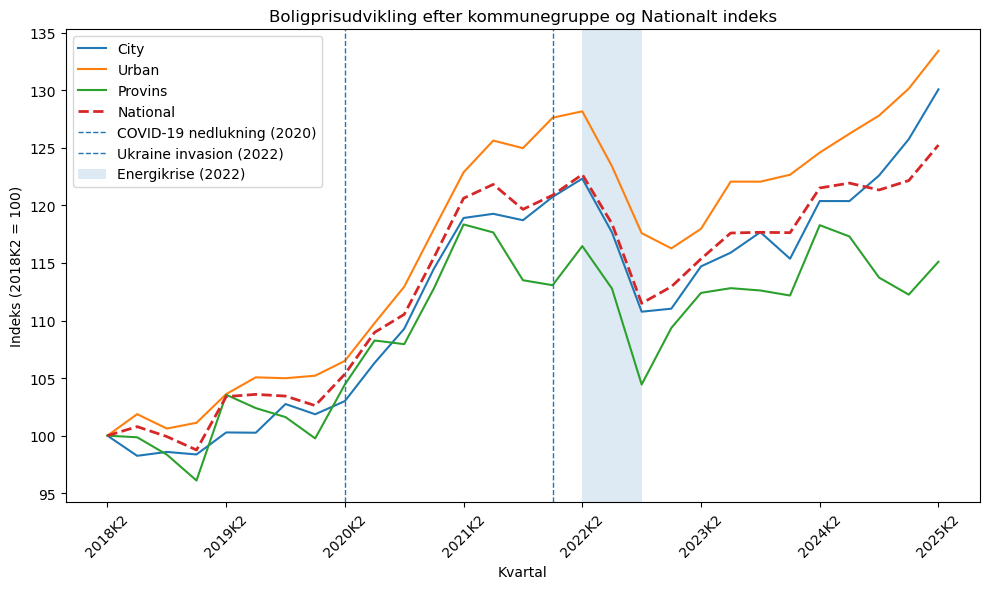

In [142]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# City og Provins
for g in ["City", "Urban", "Provins"]:
    d = compare[compare["Gruppe"] == g]
    ax.plot(d["quarter"], d["price_index"], label=g)

# National
ax.plot(compare["quarter"].unique(),
        national["national_index"],
        linestyle="--",
        linewidth=2,
        label="National")

# Markeringer (samme som før)
ax.axvline("2020K2", linestyle="--", linewidth=1, label="COVID-19 nedlukning (2020)")
ax.axvline("2022K1", linestyle="--", linewidth=1, label="Ukraine invasion (2022)")
ax.axvspan("2022K2", "2022K4", alpha=0.15, label="Energikrise (2022)")

ax.set_title("Boligprisudvikling efter kommunegruppe og Nationalt indeks")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Indeks (2018K2 = 100)")
ax.legend()

ax.set_xticks(d["quarter"][::4])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


Figuren viser boligprisudviklingen i by- og provinskommuner sammenlignet med den nationale udvikling fra 2018 til 2025. Det fremgår tydeligt, at boligpriserne i bykommuner har oplevet en markant højere vækst sammenlignet med provinskommuner og den nationale gennemsnitlige udvikling.

Provinskommunerne har haft en mere moderat stigning i boligpriserne, hvilket indikerer en forskel i markedstendenser mellem by- og provinsområder.

#### Beregning af før/efter COVID-19 prisniveauer

In [ ]:
import numpy as np

prices_long["period"] = np.where(
    prices_long["quarter"] < "2020K2",
    "Pre-COVID",
    "Post-COVID"
)

prices_long[["quarter", "period"]].drop_duplicates().head()

# Prisniveauer før/efter COVID-19
level_summary = (
    prices_long
    .groupby(["Gruppe", "period"])["price_m2"]
    .mean()
    .reset_index()
)

level_summary

,Gruppe,period,price_m2
0,City,Post-COVID,29387.220238
1,City,Pre-COVID,25145.515625
2,Provins,Post-COVID,11678.141215
3,Provins,Pre-COVID,10388.180346
4,Urban,Post-COVID,27809.989247
5,Urban,Pre-COVID,23448.683468


In [ ]:
# Vækstrater før/efter COVID-19
growth_summary = (
    prices_long
    .dropna(subset=["growth_q"])
    .groupby(["Gruppe", "period"])["growth_q"]
    .mean()
    .reset_index()
)

growth_summary

,Gruppe,period,growth_q
0,City,Post-COVID,0.008993
1,City,Pre-COVID,0.002554
2,Provins,Post-COVID,0.006629
3,Provins,Pre-COVID,-0.001625
4,Urban,Post-COVID,0.010721
5,Urban,Pre-COVID,0.006688


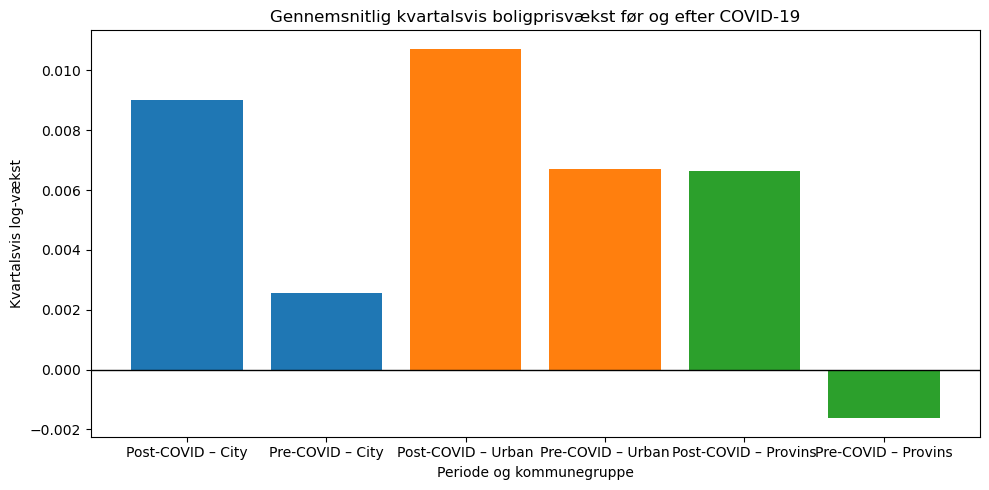

In [ ]:
# Figur til prisniveauer før/efter COVID-19
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

for g in ["City", "Urban", "Provins"]:
    d = growth_summary[growth_summary["Gruppe"] == g]
    ax.bar(
        d["period"] + " – " + g,
        d["growth_q"]
    )

ax.axhline(0, color="black", linewidth=1)
ax.set_title("Gennemsnitlig kvartalsvis boligprisvækst før og efter COVID-19")
ax.set_ylabel("Kvartalsvis log-vækst")
ax.set_xlabel("Periode og kommunegruppe")

plt.tight_layout()
plt.show()


“Figur X viser, at City-kommuner oplever en markant højere gennemsnitlig boligprisvækst i perioden efter 2020K2 sammenlignet med perioden forud for COVID-19. Provinskommuner udviser en mere afdæmpet ændring. Disse observationer dokumenterer forskellige udviklingsmønstre, men kan ikke i sig selv tolkes kausalt.”

In [ ]:
prices_long["covid_period"] = np.where(
    (prices_long["quarter"] >= "2020K2") &
    (prices_long["quarter"] <= "2021K2"),
    1,
    0
)

prices_long.groupby("quarter")["covid_period"].mean()

prices_long["treated"] = np.where(
    prices_long["Gruppe"] == "city",
    1,
    0
)
pre_data = prices_long[prices_long["quarter"] < "2020K2"].copy()
post_data = prices_long[prices_long["quarter"] > "2021K2"].copy()


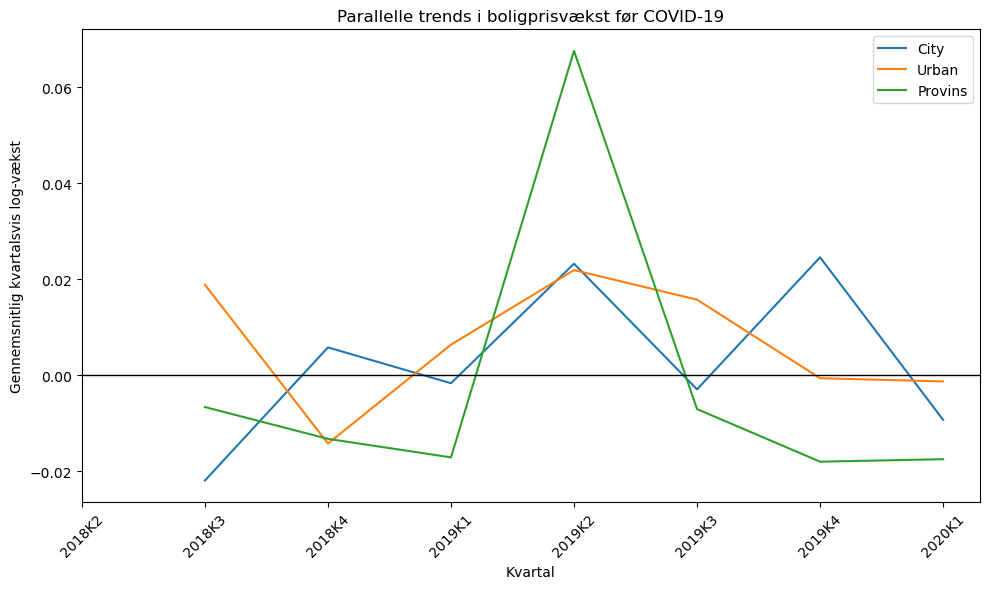

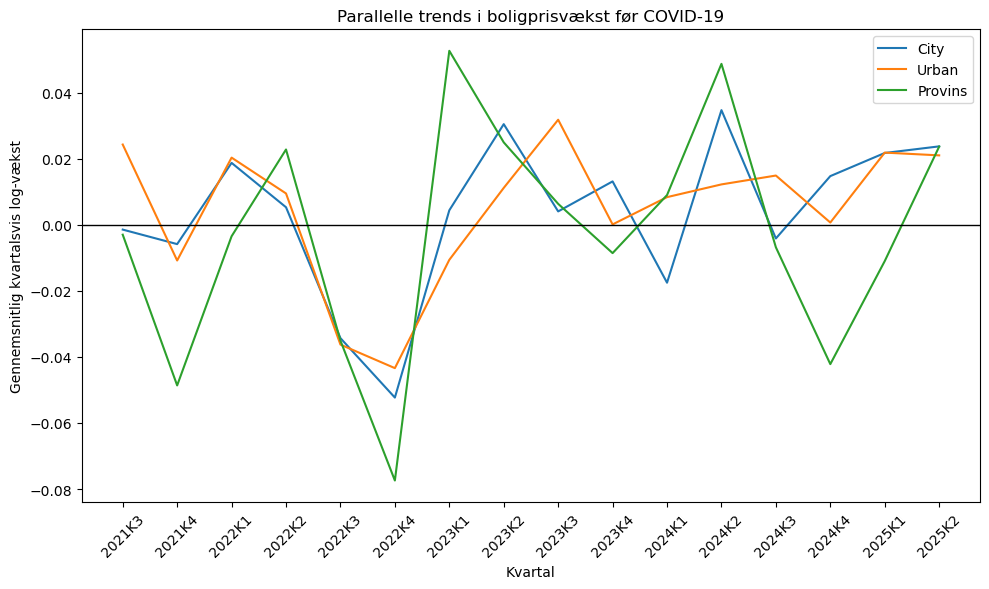

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

for g in ["City", "Urban", "Provins"]:
    d = (
        pre_data[pre_data["Gruppe"] == g]
        .groupby("quarter")["growth_q"]
        .mean()
        .reset_index()
    )
    ax.plot(d["quarter"], d["growth_q"], label=g)

ax.axhline(0, color="black", linewidth=1)
ax.set_title("Parallelle trends i boligprisvækst før COVID-19")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Gennemsnitlig kvartalsvis log-vækst")
ax.legend()

ax.set_xticks(d["quarter"])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

for g in ["City", "Urban", "Provins"]:
    d = (
        post_data[post_data["Gruppe"] == g]
        .groupby("quarter")["growth_q"]
        .mean()
        .reset_index()
    )
    ax.plot(d["quarter"], d["growth_q"], label=g)

ax.axhline(0, color="black", linewidth=1)
ax.set_title("Parallelle trends i boligprisvækst før COVID-19")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Gennemsnitlig kvartalsvis log-vækst")
ax.legend()

ax.set_xticks(d["quarter"])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

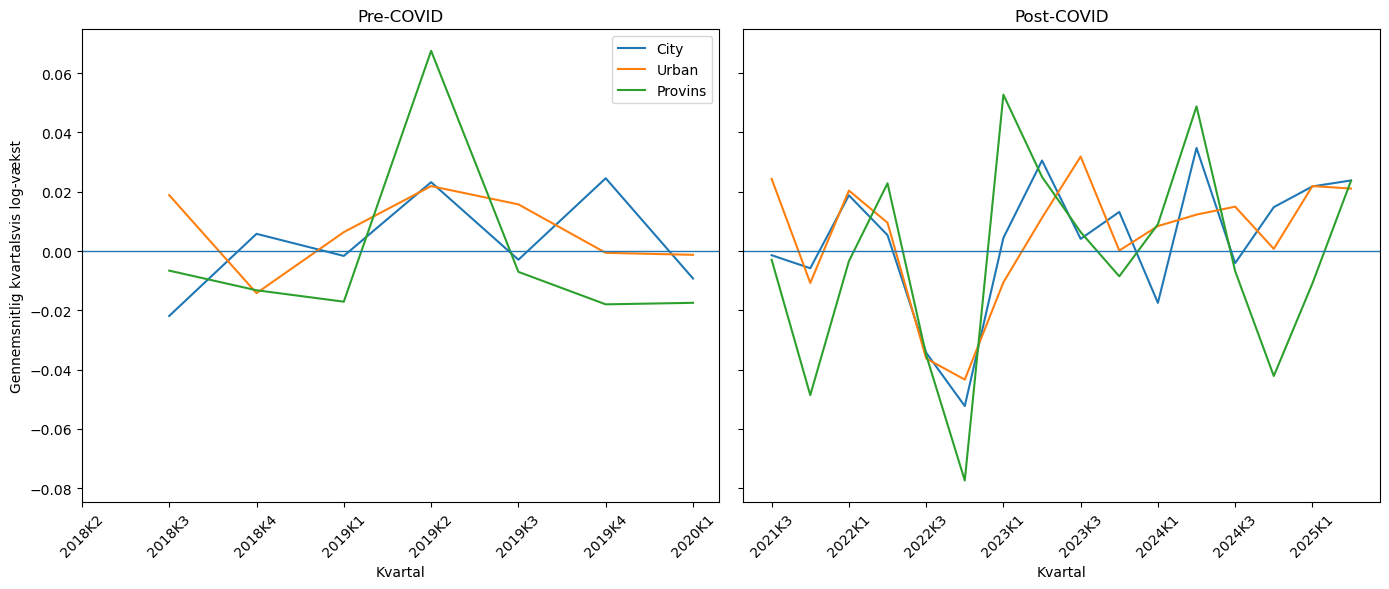

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# ---------- PRE ----------
ax = axes[0]

for g in ["City", "Urban", "Provins"]:
    d = (
        pre_data[pre_data["Gruppe"] == g]
        .groupby("quarter")["growth_q"]
        .mean()
        .reset_index()
    )
    ax.plot(d["quarter"], d["growth_q"], label=g)

ax.axhline(0, linewidth=1)
ax.set_title("Pre-COVID")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Gennemsnitlig kvartalsvis log-vækst")
ax.legend()
ax.set_xticks(d["quarter"])
ax.tick_params(axis="x", rotation=45)

# ---------- POST ----------
ax = axes[1]

for g in ["City", "Urban", "Provins"]:
    d = (
        post_data[post_data["Gruppe"] == g]
        .groupby("quarter")["growth_q"]
        .mean()
        .reset_index()
    )
    ax.plot(d["quarter"], d["growth_q"], label=g)

ax.axhline(0, linewidth=1)
ax.set_title("Post-COVID")
ax.set_xlabel("Kvartal")
ax.set_xticks(d["quarter"][::2])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.formula.api as smf

pre_trend_model = smf.ols(
    "growth_q ~ treated * t",
    data=pre_data.dropna(subset=["growth_q"])
).fit(cov_type="HC1")

pre_trend_model.summary()


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])
/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               growth_q   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.08399
Date:                Thu, 25 Dec 2025   Prob (F-statistic):              0.772
Time:                        21:38:35   Log-Likelihood:                 477.86
No. Observations:                 656   AIC:                            -951.7
Df Residuals:                     654   BIC:                            -942.7
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3140     14.881      0.290      0.772     -24.852      33.480
treated             0          0        nan        nan           0           0
t             -0.0002      0.001     -0.290      0.772      -0.002       0.001
treated:t           0          0        nan        nan           0           0
==============================================================================
Omnibus:                       75.045   Durbin-Watson:                   2.796
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              547.003
Skew:                          -0.137   Prob(JB):                    1.66e-119
Kurtosis:                       7.465   Cond. No.                          inf
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

##  Difference in Difference

#### Baseline for DiD-analyse

In [ ]:
import numpy as np

prices_long["treated"] = (prices_long["Gruppe"] == "city").astype(int)

prices_long["covid_period"] = np.where(
    (prices_long["quarter"] >= "2020K2") & (prices_long["quarter"] <= "2021K1"),
    1, 0
)


import numpy as np
import statsmodels.formula.api as smf

# outcome
prices_long["log_price"] = np.log(prices_long["price_m2"])

# Brug kun city + provins (fjern evt. andre grupper)
did_df = prices_long[prices_long["Gruppe"].isin(["City", "Provins"])].copy()

# Hold dig til pre + COVID-vinduet (så DID er helt ren)
did_df = did_df[(did_df["quarter"] < "2020K2") | (did_df["covid_period"] == 1)].copy()

# DiD 2-way FE
mod = smf.ols(
    "log_price ~ treated * covid_period + C(ID) + C(quarter)",
    data=did_df
).fit(cov_type="cluster", cov_kwds={"groups": did_df["ID"]})

print(mod.summary().tables[1])


In [147]:
import numpy as np

# hvis ikke allerede gjort
prices_long["log_price"] = np.log(prices_long["price_m2"])
prices_long["growth_q"] = (
    prices_long
    .groupby("ID")["log_price"]
    .diff()
)


In [148]:
growth_by_group = (
    prices_long
    .dropna(subset=["growth_q"])
    .groupby(["Gruppe", "quarter"])["growth_q"]
    .mean()
    .reset_index()
)

growth_by_group.head()


,Gruppe,quarter,growth_q
0,City,2018K3,-0.021903
1,City,2018K4,0.005812
2,City,2019K1,-0.001647
3,City,2019K2,0.023241
4,City,2019K3,-0.002925


In [149]:
growth_wide = growth_by_group.pivot(
    index="quarter",
    columns="Gruppe",
    values="growth_q"
).reset_index()

growth_wide.head()


Gruppe,quarter,City,Provins,Urban
0,2018K3,-0.021903,-0.006606,0.018860
1,2018K4,0.005812,-0.013231,-0.014206
2,2019K1,-0.001647,-0.017085,0.006383
3,2019K2,0.023241,0.067560,0.021909
4,2019K3,-0.002925,-0.007030,0.015749


In [152]:
growth_wide["diff_prov_city"] = (
    growth_wide["Provins"] - growth_wide["City"]
)

growth_wide["diff_urban_city"] = (
    growth_wide["Urban"] - growth_wide["City"]
)

growth_wide.head()


Gruppe,quarter,City,Provins,Urban,diff_prov_city,diff_urban_city
0,2018K3,-0.021903,-0.006606,0.018860,0.015297,0.040763
1,2018K4,0.005812,-0.013231,-0.014206,-0.019043,-0.020017
2,2019K1,-0.001647,-0.017085,0.006383,-0.015438,0.008031
3,2019K2,0.023241,0.067560,0.021909,0.044320,-0.001332
4,2019K3,-0.002925,-0.007030,0.015749,-0.004105,0.018674


In [153]:
growth_wide["period"] = np.where(
    growth_wide["quarter"] < "2020K2",
    "Pre-COVID",
    "Post-COVID"
)

growth_wide.groupby("period")["diff_prov_city"].mean()


period
Post-COVID   -0.002364
Pre-COVID    -0.004246
Name: diff_prov_city, dtype: float64

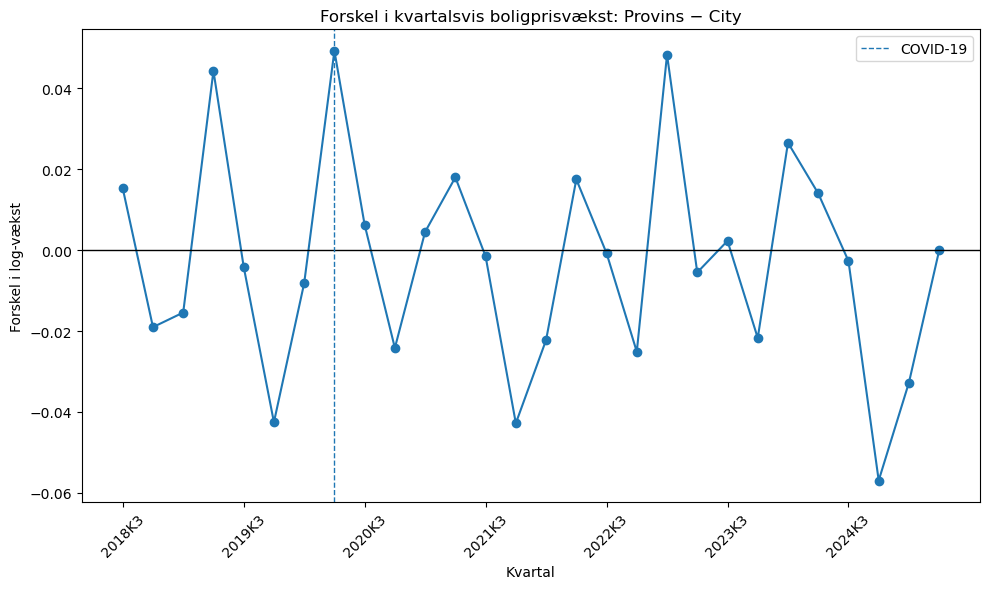

In [154]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    growth_wide["quarter"],
    growth_wide["diff_prov_city"],
    marker="o"
)

ax.axhline(0, color="black", linewidth=1)
ax.axvline("2020K2", linestyle="--", linewidth=1, label="COVID-19")

ax.set_title("Forskel i kvartalsvis boligprisvækst: Provins − City")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Forskel i log-vækst")
ax.legend()

ax.set_xticks(growth_wide["quarter"][::4])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


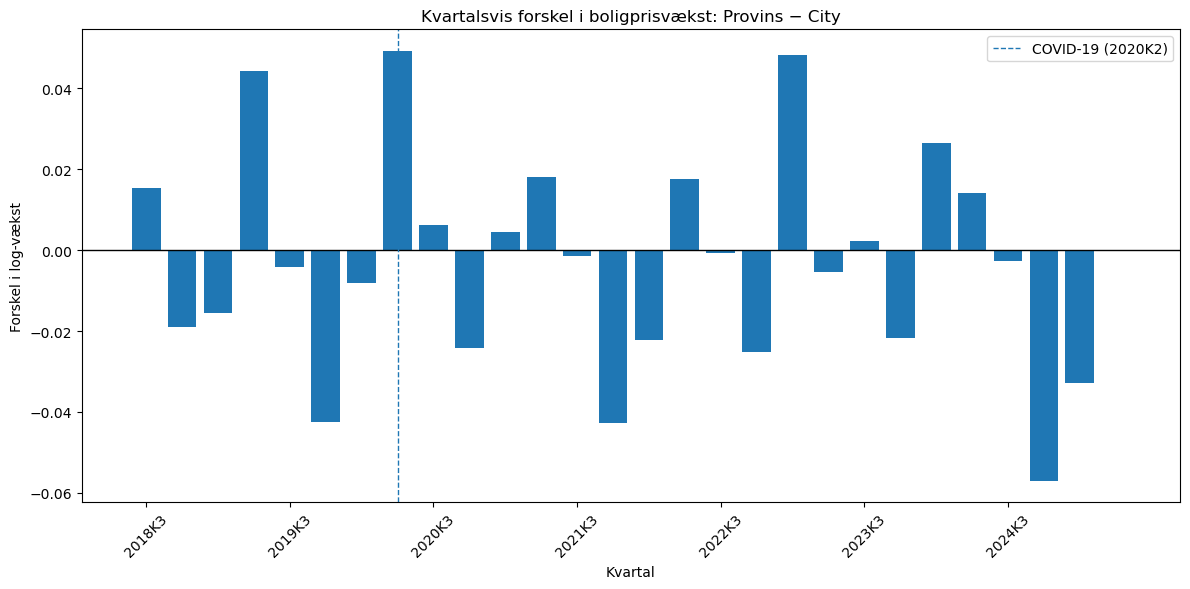

In [157]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    growth_wide["quarter"],
    growth_wide["diff_prov_city"]
)

# nul-linje
ax.axhline(0, color="black", linewidth=1)

# COVID markering
ax.axvline("2020K2", linestyle="--", linewidth=1, label="COVID-19 (2020K2)")

ax.set_title("Kvartalsvis forskel i boligprisvækst: Provins − City")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Forskel i log-vækst")
ax.legend()

# Gør x-aksen læsbar (vis hvert 4. kvartal)
ax.set_xticks(growth_wide["quarter"][::4])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


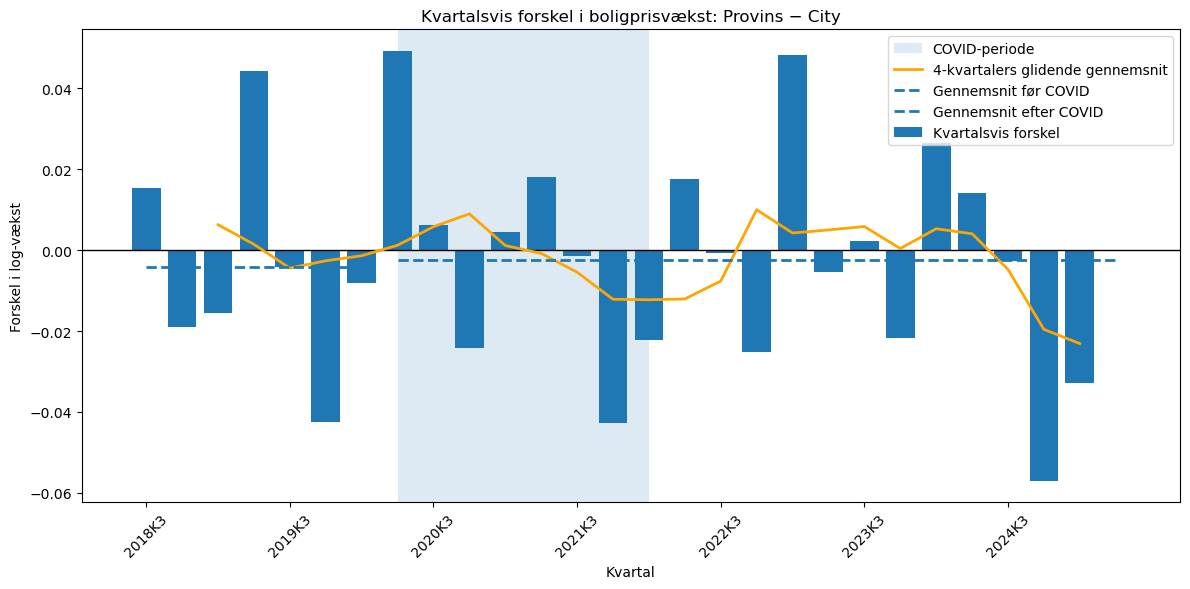

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# -----------------------------
# Grundfigur: kvartalsvise søjler
# -----------------------------
ax.bar(
    growth_wide["quarter"],
    growth_wide["diff_prov_city"],
    label="Kvartalsvis forskel"
)

# nul-linje
ax.axhline(0, color="black", linewidth=1)

# COVID markering
#ax.axvspan("2020K2", linestyle="--", linewidth=1, label="COVID-19")
ax.axvspan(
    "2020K2",
    "2022K1",
    alpha=0.15,           # gennemsigtighed
    label="COVID-periode"
)


# =========================================================
# OPTION A — Glidende gennemsnit (udjævning)
# Slå TIL/FRA ved at kommentere disse linjer
# =========================================================

growth_wide["ma_4q"] = (
     growth_wide["diff_prov_city"]
     .rolling(window=4, center=True)
     .mean()
 )

ax.plot(
     growth_wide["quarter"],
     growth_wide["ma_4q"],
     linewidth=2,
     color="orange",
     label="4-kvartalers glidende gennemsnit"
 )



# -----------------------------
# Layout og labels
# -----------------------------
ax.set_title("Kvartalsvis forskel i boligprisvækst: Provins − City")
ax.set_xlabel("Kvartal")
ax.set_ylabel("Forskel i log-vækst")
ax.legend()

# Gør x-aksen læsbar (vis hvert 4. kvartal)
ax.set_xticks(growth_wide["quarter"][::4])
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


Figuren viser boligprisudviklingen i by- og provinskommuner sammenlignet med den nationale udvikling fra 2010 til 2023. Det fremgår tydeligt, at boligpriserne i bykommuner har oplevet en markant højere vækst sammenlignet med provinskommuner og den nationale gennemsnitlige udvikling.